# Video Games Sales

## Goal

You work for a data science consulting company. A major video game production company has retained your firm to conduct market research into the video game industry. They've furnished you with video game sales data for the last thirty years (described below) and, as a first project, would like to know:
- What are some major differences between the North American, European, and Japanese video game markets?
- What video game genres are trending in each market?
- What features about a video game are most indicative of its success?

## The Data

This dataset contains a list of video games with sales greater than 100,000 copies.

Rank - Ranking of overall sales  
Name - The games name  
Platform - Platform of the games release (i.e. PC,PS4, etc.)  
Year - Year of the game's release  
Genre - Genre of the game  
Publisher - Publisher of the game  
NA_Sales - Sales in North America (in millions)  
EU_Sales - Sales in Europe (in millions)  
JP_Sales - Sales in Japan (in millions)  
Other_Sales - Sales in the rest of the world (in millions)  
Global_Sales - Total worldwide sales.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Load and Explore Data

Treat Platform, Genre, and Publisher as categorical data

In [2]:
dtypes = {'Platform':'category',
          'Genre':'category',
          'Publisher':'category'}

Load the data and ignore games that are missing data

In [3]:
df = (pd
      .read_csv('vgsales.csv',
                 dtype=dtypes)
      .dropna())

Convert the year to integer

In [4]:
df['Year'] = (df['Year']
              .astype('int64'))

Briefly explore the data

In [6]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16291 non-null int64
Name            16291 non-null object
Platform        16291 non-null category
Year            16291 non-null int64
Genre           16291 non-null category
Publisher       16291 non-null category
NA_Sales        16291 non-null float64
EU_Sales        16291 non-null float64
JP_Sales        16291 non-null float64
Other_Sales     16291 non-null float64
Global_Sales    16291 non-null float64
dtypes: category(3), float64(5), int64(2), object(1)
memory usage: 2.4 MB


# What are some major differences between the North American, European, and Japanese video game markets?

Market Sizes: North America is the largest

In [8]:
df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].agg('sum')

NA_Sales       4327.65
EU_Sales       2406.69
JP_Sales       1284.27
Other_Sales     788.91
dtype: float64

Nintendo dominates the Japanese market -- 125 titles w/ more than 1 millions in sales. Next highest is Sony with 16

In [9]:
df[df['JP_Sales'] > 1]['Publisher'].value_counts()[:10]

Nintendo                        125
Sony Computer Entertainment      16
SquareSoft                       14
Namco Bandai Games               12
Konami Digital Entertainment     11
Enix Corporation                 11
Square Enix                      10
Capcom                           10
Hudson Soft                       4
ASCII Entertainment               4
Name: Publisher, dtype: int64

# What video game genres are trending in each market?

Group by Genre and sum over Sales

In [10]:
market_sales = (df
                .groupby('Genre')
                .agg('sum')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']])

and Sales as a fraction of the total for a given Market

In [11]:
for column in market_sales.columns:
    market_sales[column + '_frac'] = market_sales[column] / df[column].agg('sum')

Plot sales per market per genre

<IPython.core.display.Javascript object>


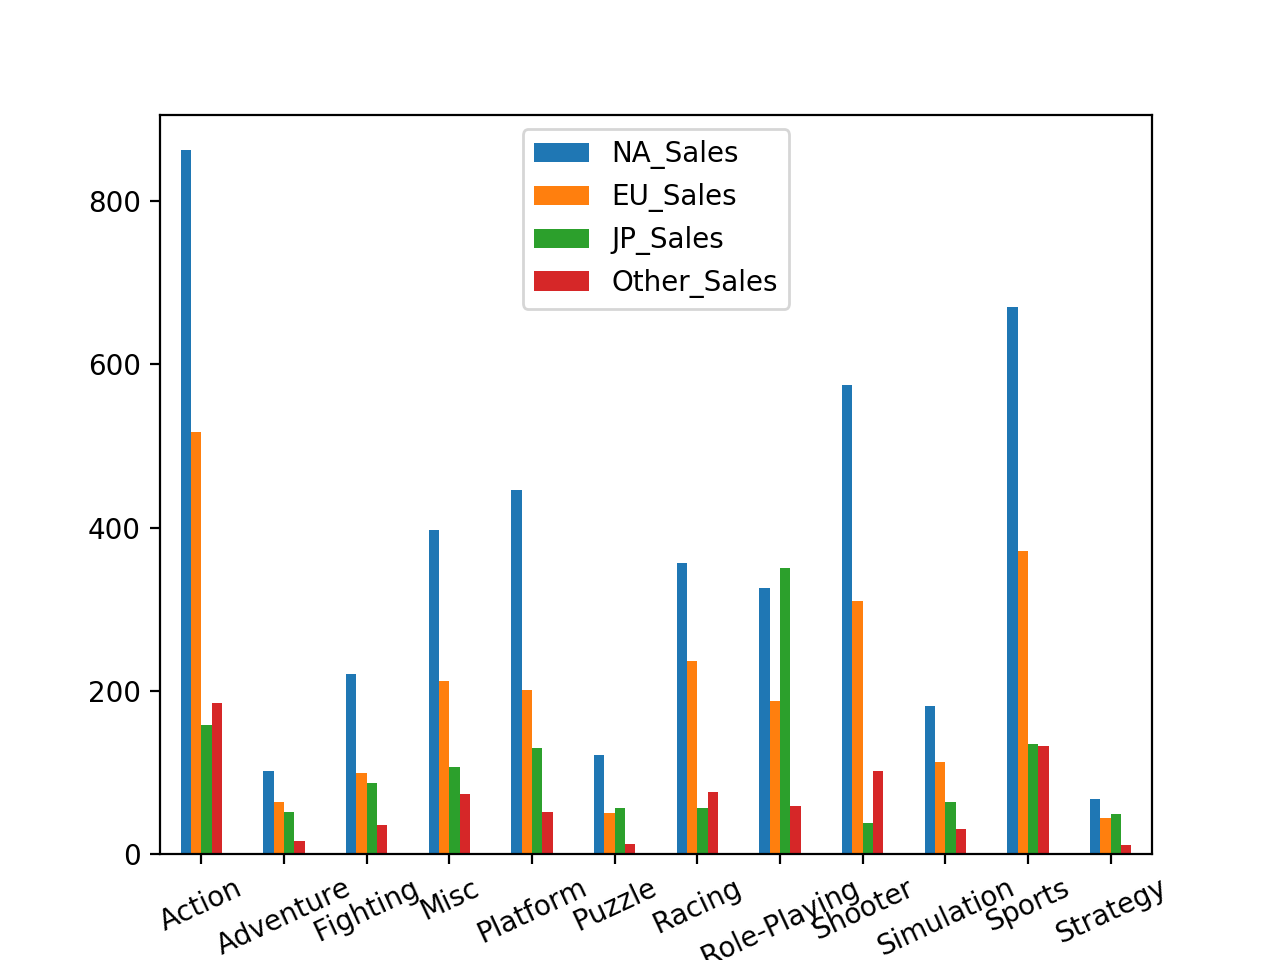

In [12]:
(market_sales[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
 .plot
 .bar(rot=25));

Now plot sales per genre normalized to the total sales in that market. Role-Playing games are most popular in Japan, while Action, Sport, and Shooter are the top 3 for the all the other markets

<IPython.core.display.Javascript object>


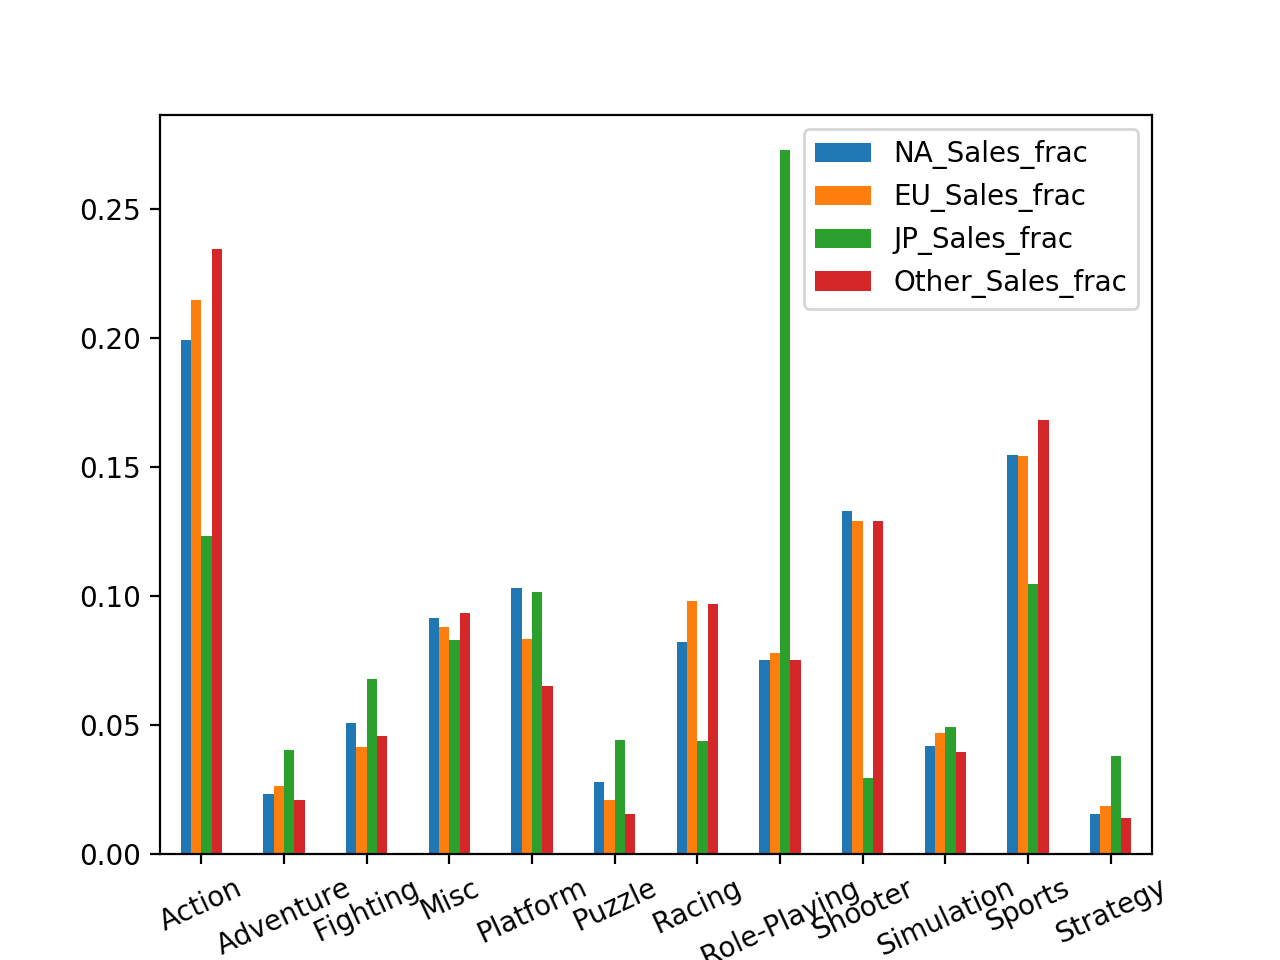

In [13]:
(market_sales[['NA_Sales_frac', 'EU_Sales_frac', 'JP_Sales_frac', 'Other_Sales_frac']]
 .plot
 .bar(rot=25));

# What features about a video game are most indicative of its success?

Use Random Forest to determine Feature Importance

In [14]:
from sklearn.ensemble import RandomForestRegressor

Pandas does the one-hot encoding for us

In [15]:
for key in dtypes.keys():
    df[key + '_codes'] = (df[key].cat.codes)

In [41]:
X = df[['Year', 'Publisher_codes', 'Genre_codes', 'Platform_codes']]
y = df['Global_Sales'].values

How deep should we make our trees?

In [19]:
from sklearn.model_selection import GridSearchCV, KFold

In [42]:
rfr = RandomForestRegressor(n_estimators=100)
params = {'max_depth':[2, 3, 5, 10, None]}

In [43]:
rf_gs = GridSearchCV(rfr,
                     param_grid=params,
                     scoring='neg_mean_squared_error',
                     cv=KFold(n_splits=5, shuffle=True),
                     return_train_score=False)

In [44]:
rf_gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [45]:
rf_gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

The best model had a `max_depth` of 5. Now lets looks at feature importance

In [46]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=5)
rfr.fit(X, y)
rfr.feature_importances_

array([0.25955453, 0.46302288, 0.1406057 , 0.13681689])

Does looking at the z_score of the sales (with respect to the year) change our conclusions?

In [30]:
year_sales = (df
              .groupby('Year')
              .agg(['mean', 'std'])['Global_Sales'])

In [31]:
df = df.merge(year_sales,
              how='outer',
              left_on='Year',
              right_index=True)

In [32]:
df['Global_Sales_zScore'] = (df['Global_Sales'] - df['mean']) / df['std']

There was one game that was said to be made in the year 2020. Remove it

In [47]:
X = df[df['Year'] < 2019][['Year', 'Publisher_codes', 'Genre_codes', 'Platform_codes']]
y = df[df['Year'] < 2019]['Global_Sales_zScore'].values

In [48]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=5)
rfr.fit(X, y)
rfr.feature_importances_

array([0.13334444, 0.55058845, 0.16896113, 0.14710599])

Not surprisingly year is now the least important feature as we've already incorporated year info into our target values